### Stack Classifer Used to determine the final predictive ability of all the other models

In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier, to_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [245]:
data_path = '/Users/andreslopez/Desktop/ECE3039/Project/survey _lung_cancer.csv'
df = pd.read_csv(data_path)

xvalue = df.drop(['LUNG_CANCER','AGE','GENDER'], axis=1).applymap(lambda x: 'NO' if x == 1 else 'YES')
xvar = df[['AGE']]
xvalue = pd.concat([df['GENDER'],xvalue], axis=1)
x_label = pd.concat([df['AGE'],xvalue], axis=1)
x_label = x_label.columns
xvalue = pd.get_dummies(xvalue)
X = pd.concat([xvar,xvalue], axis=1)
X = X.astype(int)
y = df['LUNG_CANCER'].apply(lambda x: 1 if x == 'YES' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/var/folders/wh/5rf3n2rs4875gpzdn9xgsbnw0000gn/T/ipykernel_41139/25917323.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  xvalue = df.drop(['LUNG_CANCER','AGE','GENDER'], axis=1).applymap(lambda x: 'NO' if x == 1 else 'YES')


In [246]:
base_estimators = [
    ('knn', KNeighborsClassifier(n_neighbors = 12)),
    ('xgb', XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=100, random_state=42, objective='binary:logistic', eval_metric='logloss')),
    ('rf', RandomForestClassifier(n_estimators=80, max_samples=0.5, max_features=0.3, max_depth=9)),
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier(random_state=42, max_depth=2, criterion="gini")),

]

# Define the stacking classifier with XGBoost as the meta-classifier
stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss')
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    y_t = y_t.values.ravel()
    y_val = y_val.values.ravel()

    stacking_model.fit(X_t, y_t)
    accuracy.append(stacking_model.score(X_val, y_val))

    print(f"Validation Precentage Complete: {int(fold_idx*100/4)}")

Validation Precentage Complete: 0
Validation Precentage Complete: 25
Validation Precentage Complete: 50
Validation Precentage Complete: 75
Validation Precentage Complete: 100


Average Cross-Validation Accuracy: 0.8906938775510204


(1.0, 5.0)

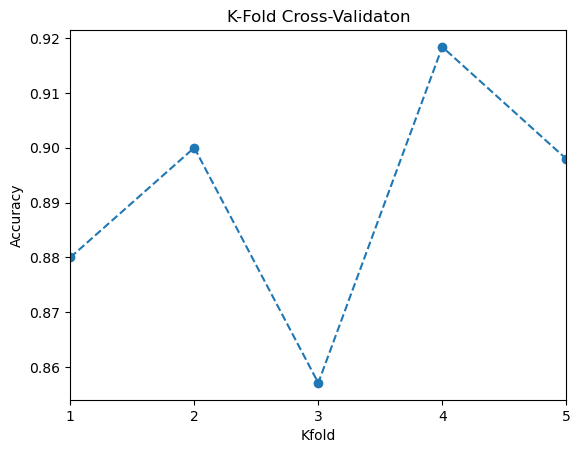

In [247]:
print(f'Average Cross-Validation Accuracy: {sum(accuracy)/(len(accuracy))}')
plt.plot(range(1,len(accuracy)+1), accuracy, marker = 'o', linestyle = '--')
plt.title("K-Fold Cross-Validaton"); plt.ylabel('Accuracy')
plt.xlabel('Kfold')
plt.xticks(range(1,len(accuracy)+1))
plt.xlim(1,len(accuracy))

/Users/andreslopez/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andreslopez/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


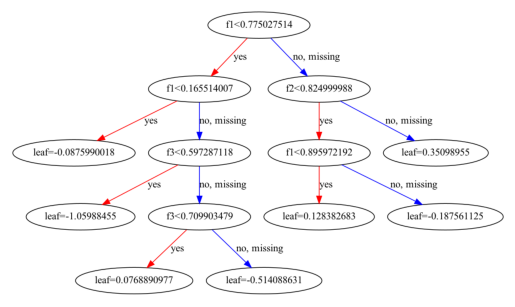

In [248]:
from xgboost import plot_tree

# Fit the stacking model
stacking_model.fit(X_train, y_train)

xgb_classifier = stacking_model.final_estimator_

plot_tree(xgb_classifier)
plt.show()


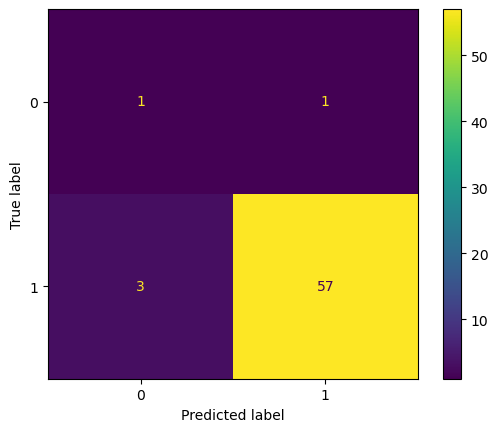


Precision: 0.9827586206896551
Recall: 0.95
F1_score: 0.9661016949152542


In [249]:
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm)

disp.plot()
plt.show()

print(f'\nPrecision: {precision}')
print(f'Recall: {recall}')
print(f"F1_score: {f1}")